<a href="https://colab.research.google.com/github/NirachaNick/SignLanguageRecognition-ML/blob/main/Final_3DCNN_SignLanguage_Sliding_window_L2_0_008.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the required libraries.
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [ ]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

Data Visualization

In [ ]:
# Get the names of all classes/categories in train_videos
all_classes_names = os.listdir('/content/drive/MyDrive/ProjectResearchMsc/Train_videos/train_video-complete')



In [ ]:
# Specify the height and width to which each video frame will be resized in  dataset.
IMAGE_HEIGHT, IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 50

# Specify the stride for the sliding window
STRIDE = 5

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "/content/drive/MyDrive/ProjectResearchMsc/Train_videos/train_video-complete"

# Specify the list containing the names of the classes used for training.
#CLASSES_LIST = ["book", "drink", "computer", "before","chair","go"]
CLASSES_LIST = ["deaf", "help", "no", "thin","walk","yes","finish","hot","many","bad"]
#CLASSES_LIST = ["book", "drink", "computer", "before","chair","go","clothes","who","candy","cousin","deaf","fine","help","no","thin","walk"]

def frames_extraction(video_file_path):
    video_reader = cv2.VideoCapture(video_file_path)
    frames = []

    while True:
        success, frame = video_reader.read()
        if not success:
            break

        # Resize and normalize the frame
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0

        frames.append(normalized_frame)

    video_reader.release()
    return frames

def sliding_window(sequence, window_size, stride):
    num_samples = (len(sequence) - window_size) // stride + 1
    sub_sequences = [sequence[i:i + window_size] for i in range(0, num_samples * stride, stride)]
    return np.array(sub_sequences)

def create_dataset():
    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')

        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))

        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            video_frames = frames_extraction(video_file_path)

            if len(video_frames) >= SEQUENCE_LENGTH:
                sub_sequences = sliding_window(video_frames, SEQUENCE_LENGTH, STRIDE)
                features.extend(sub_sequences)
                labels.extend([class_index] * len(sub_sequences))
                video_files_paths.extend([video_file_path] * len(sub_sequences))

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

# Create the dataset.
features, labels, video_files_paths = create_dataset()

# Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)




Extracting Data of Class: deaf
Extracting Data of Class: help
Extracting Data of Class: no
Extracting Data of Class: thin
Extracting Data of Class: walk
Extracting Data of Class: yes
Extracting Data of Class: finish
Extracting Data of Class: hot
Extracting Data of Class: many
Extracting Data of Class: bad


In [ ]:
# Split the Data into Train (75%), Validation and Test Set (25%).
features_train, features_temp, labels_train, labels_temp = train_test_split(
    features, one_hot_encoded_labels, test_size=0.25, shuffle=True, random_state=seed_constant
)
features_val, features_test, labels_val, labels_test = train_test_split(
    features_temp, labels_temp, test_size=0.5, shuffle=True, random_state=seed_constant
)

# Display the shapes of the datasets
print("Train Features shape:", features_train.shape)
print("Train Labels shape:", labels_train.shape)
print("Validation Features shape:", features_val.shape)
print("Validation Labels shape:", labels_val.shape)
print("Test Features shape:", features_test.shape)
print("Test Labels shape:", labels_test.shape)

Train Features shape: (467, 50, 64, 64, 3)
Train Labels shape: (467, 10)
Validation Features shape: (78, 50, 64, 64, 3)
Validation Labels shape: (78, 10)
Test Features shape: (78, 50, 64, 64, 3)
Test Labels shape: (78, 10)


Preprocess Data

Construct the CNN3D Model

In [ ]:
import time  # Import the time module
# Record the start time
start_time = time.time()
#CNN3D
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2

def create_CNN3D_model():
    '''
    This function will construct a 3D Convolutional Neural Network (3DCNN) model.
    Returns:
        model: The constructed 3DCNN model.
    '''

    # Create a Sequential model
    model = Sequential()

    # Define the Model Architecture
    ###################################################################

    model.add(Conv3D(16, (3, 3, 3), padding='same', activation='relu',
                     input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(MaxPooling3D((1, 4, 4)))
    #model.add(Dropout(0.5))

    model.add(Conv3D(32, (3, 3, 3), padding='same', activation='relu'))
    model.add(MaxPooling3D((1, 4, 4)))
    #model.add(Dropout(0.5))

    model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
    model.add(MaxPooling3D((1, 2, 2)))
    #model.add(Dropout(0.5))

    model.add(Conv3D(64, (3, 3, 3), padding='same', activation='relu'))
    model.add(MaxPooling3D((1, 2, 2)))
    #model.add(Dropout(0.5))
    # Add L2 regularization to layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.08)))
    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(len(CLASSES_LIST), activation='softmax'))




    ###################################################################

    # Display the model's summary
    model.summary()

    return model

# Create the 3DCNN model
CNN3D_model = create_CNN3D_model()

# Display the success message
print("CNN3D Model Created Successfully!")



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 50, 64, 64, 16)    1312      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 50, 16, 16, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 50, 16, 16, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 50, 4, 4, 32)     0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 50, 4, 4, 64)      55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 50, 2, 2, 64)     0

In [ ]:
# Create an Instance of Early Stopping Callback.
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 20, mode = 'min', restore_best_weights = True)

# Compile the model and specify loss function, optimizer and metrics to the model.
CNN3D_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])

# Start training the model.
CNN3D_model_training_history = CNN3D_model.fit(x=features_train, y=labels_train, epochs=200, batch_size=16,
                                            shuffle=True, validation_data=(features_val, labels_val),
                                            callbacks=[early_stopping_callback])
#CNN3D_model_training_history = CNN3D_model.fit(x=features_train, y=labels_train, epochs=50, batch_size=8,
                                            #shuffle=True, validation_data=(features_val, labels_val))



Epoch 1/200
30/30 [==============================] - 14s 62ms/step - loss: 7.5568 - accuracy: 0.1263 - val_loss: 6.1618 - val_accuracy: 0.1410
Epoch 2/200
30/30 [==============================] - 1s 25ms/step - loss: 5.2543 - accuracy: 0.1413 - val_loss: 4.4372 - val_accuracy: 0.1410
Epoch 3/200
30/30 [==============================] - 1s 25ms/step - loss: 3.7928 - accuracy: 0.2077 - val_loss: 3.1364 - val_accuracy: 0.2821
Epoch 4/200
30/30 [==============================] - 1s 25ms/step - loss: 2.6751 - accuracy: 0.3212 - val_loss: 2.3313 - val_accuracy: 0.3846
Epoch 5/200
30/30 [==============================] - 1s 25ms/step - loss: 2.0093 - accuracy: 0.4218 - val_loss: 1.6130 - val_accuracy: 0.5897
Epoch 6/200
30/30 [==============================] - 1s 25ms/step - loss: 1.4389 - accuracy: 0.5717 - val_loss: 1.3018 - val_accuracy: 0.6154
Epoch 7/200
30/30 [==============================] - 1s 25ms/step - loss: 1.1439 - accuracy: 0.6767 - val_loss: 1.1751 - val_accuracy: 0.6923
Epoch

Model Evaluation

In [ ]:
# Evaluate the trained model.
model_evaluation_history = CNN3D_model.evaluate(features_test, labels_test)
# Record the end time
end_time = time.time()
# Calculate and print the execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")

3/3 [==============================] - 0s 21ms/step - loss: 0.3176 - accuracy: 0.9359
Execution time: 101.29 seconds


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
#model_file_name = f'CNN3D_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
model_file_name='/content/drive/MyDrive/ProjectResearchMsc/Model/CNN3D_slidingWindow_l2_0.08.h5'
# Save the Model.
CNN3D_model.save(model_file_name)

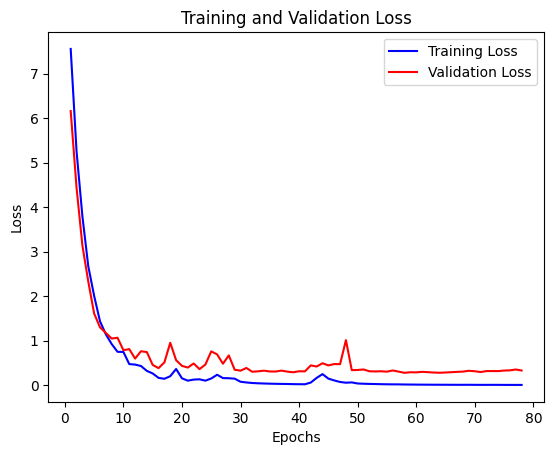

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have the training history stored in the variable 'CNN3D_model_training_history'
train_loss = CNN3D_model_training_history.history['loss']
val_loss = CNN3D_model_training_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the training and validation loss
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


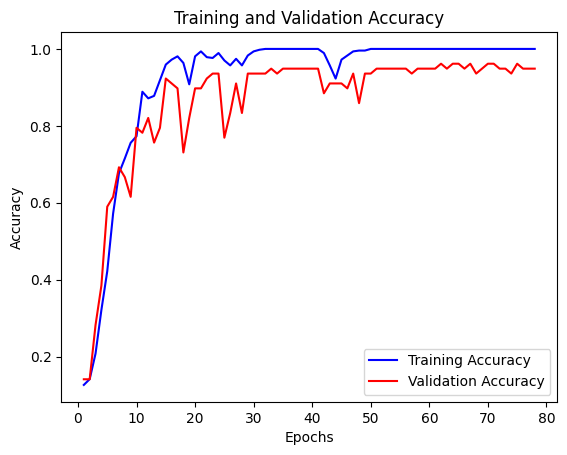

In [ ]:
train_accuracy = CNN3D_model_training_history.history['accuracy']
val_accuracy = CNN3D_model_training_history.history['val_accuracy']
epochs = range(1, len(train_accuracy) + 1)

# Plot the training and validation accuracy
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

3/3 [==============================] - 0s 19ms/step


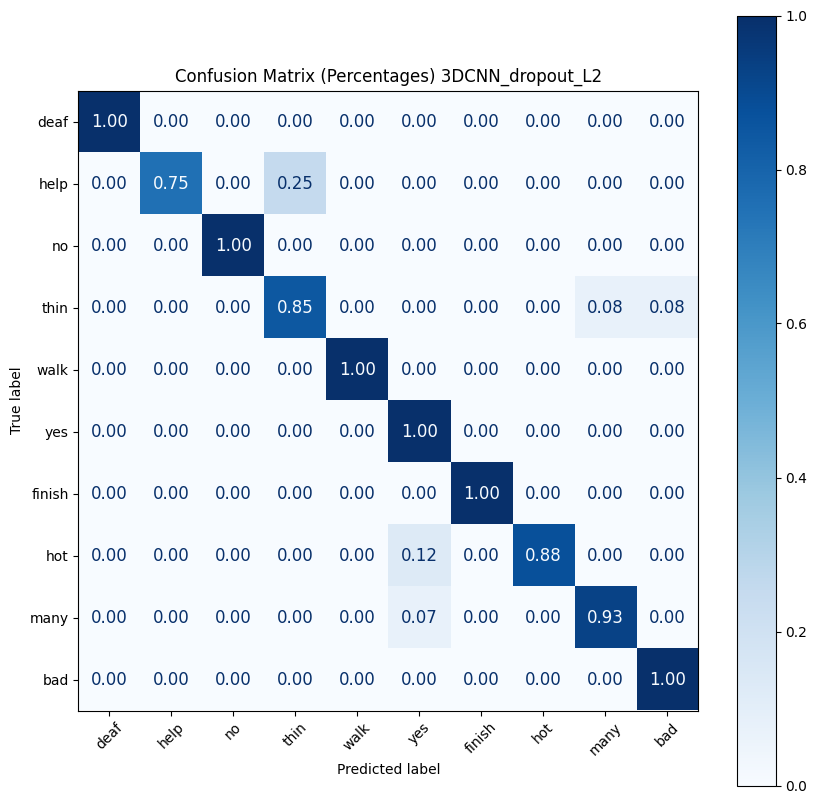

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Evaluate your model on the test data and get the predicted labels
predicted_labels = CNN3D_model.predict(features_test)
predicted_labels = np.argmax(predicted_labels, axis=1)  # Convert one-hot encoded predictions to class indices

# Get the true labels (assuming you already have them)
true_labels = np.argmax(labels_test, axis=1)  # Convert one-hot encoded true labels to class indices

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate the row sums (total samples per class)
row_sums = conf_matrix.sum(axis=1, keepdims=True)

# Normalize the confusion matrix to percentages
conf_matrix_percent = conf_matrix / row_sums

# Plot the confusion matrix with percentages
class_names = CLASSES_LIST  # Replace with your class names
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust the figure size
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_percent, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format=".2f", ax=ax)  # Use ".2f" to format percentages with two decimal places
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title("Confusion Matrix (Percentages) 3DCNN_dropout_L2")

# Adjust font size for better readability of numbers
for text in disp.text_.ravel():
    text.set_fontsize(12)

plt.show()


In [ ]:
# the true labels for the training data stored in 'labels_train'

# Use the trained model to predict the labels for the training data
predicted_labels_train = CNN3D_model.predict(features_train)

# Convert the predicted labels to one-hot-encoded format
predicted_labels_train_onehot = np.argmax(predicted_labels_train, axis=1)

# Print the shape of the predicted_labels_train_onehot array (optional, for verification)
print("Shape of predicted_labels_train_onehot:", predicted_labels_train_onehot.shape)

# Now, you can proceed to calculate and print the classification report for the training data
from sklearn.metrics import classification_report

# Get the classification report for the training data
classification_report_train = classification_report(labels_train.argmax(axis=1), predicted_labels_train_onehot, target_names=CLASSES_LIST)

# Print the classification report
print("[INFO] evaluation testing for training data ...\n", classification_report_train)

# Get the classification report for the validation data
print("[INFO] evaluation testing for validation data ...")
predictions_val = CNN3D_model.predict(features_val, batch_size=2)  # Change 'batch_size' to the desired value
classification_report_val = classification_report(labels_val.argmax(axis=1), predictions_val.argmax(axis=1), target_names=CLASSES_LIST)

# Print the classification report for validation data
print(classification_report_val)

# Get the classification report for the test data
print("[INFO] evaluation testing for test data ...")
predictions_test = CNN3D_model.predict(features_test, batch_size=2)  # Change 'batch_size' to the desired value
classification_report_test = classification_report(labels_test.argmax(axis=1), predictions_test.argmax(axis=1), target_names=CLASSES_LIST)

# Print the classification report for test data
print(classification_report_test)


15/15 [==============================] - 1s 37ms/step
Shape of predicted_labels_train_onehot: (467,)
[INFO] evaluation testing for training data ...
               precision    recall  f1-score   support

        deaf       1.00      1.00      1.00        59
        help       1.00      1.00      1.00        32
          no       1.00      1.00      1.00        59
        thin       1.00      1.00      1.00        36
        walk       1.00      1.00      1.00        74
         yes       1.00      1.00      1.00        39
      finish       1.00      1.00      1.00        44
         hot       1.00      1.00      1.00        45
        many       1.00      1.00      1.00        51
         bad       1.00      1.00      1.00        28

    accuracy                           1.00       467
   macro avg       1.00      1.00      1.00       467
weighted avg       1.00      1.00      1.00       467

[INFO] evaluation testing for validation data ...
39/39 [==============================] - 

Test with test Video

In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.6/188.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 112.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 341.8/341.8 kB 38.1 MB/s eta 0:00:00
  Attempting uninstall: tzlocal
    Found existing installation: tzlocal 5.0.1
    Uninstalling tzlocal-5.0.1:
      Successfully uninstalled tzlocal-5.0.1


In [ ]:
import streamlit as st
import numpy as np
from tensorflow.keras.models import load_model
import cv2
import tempfile
import os
from collections import Counter

# Load your pre-trained model and perform other operations
CNN3D_model = load_model('/content/drive/MyDrive/ProjectResearchMsc/Model/CNN3D_slidingWindow_l2.h5')
CNN3D_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'], run_eagerly=True)
CLASSES_LIST = ["deaf", "help", "no", "thin","walk","yes","finish","hot","many","bad"]

st.title('Sign Language Classification Using Machine Learning')

# Use Streamlit's file_uploader to allow users to upload a video
video_path = st.file_uploader("Upload a video", type=["mp4", "MOV"])

if video_path is not None:
    st.write("Processing video...")
    st.video(video_path)

    # Create a temporary directory to store the uploaded video
    temp_dir = tempfile.mkdtemp()
    temp_video_path = os.path.join(temp_dir, "temp_video.mp4")

    # Write the uploaded video to the temporary directory
    with open(temp_video_path, "wb") as temp_video_file:
        temp_video_file.write(video_path.read())

    # Initialize an empty list to store video frames
    video_frames = []

    # Open the uploaded video file using OpenCV
    cap = cv2.VideoCapture(temp_video_path)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        # Resize frame to match model's input shape (64x64)
        frame = cv2.resize(frame, (64, 64))

        video_frames.append(frame)

    cap.release()

    # Normalize pixel values
    video_frames = np.array(video_frames) / 255.0

    # Organize frames into sequences with length 50
    sequence_length = 50
    num_frames = len(video_frames)

    sequences = []
    for i in range(0, num_frames - sequence_length + 1, sequence_length):
        sequence = video_frames[i:i + sequence_length]
        sequences.append(sequence)

    sequences = np.array(sequences)

    predictions = CNN3D_model.predict(sequences)

    # Assuming predictions contain class probabilities
    predicted_class_indices = np.argmax(predictions, axis=-1)
    predicted_labels = [CLASSES_LIST[i] for i in predicted_class_indices]

    # Count the occurrences of each label
    label_counts = Counter(predicted_labels)

    # Calculate the percentage of each label
    total_labels = len(predicted_labels)
    label_percentages = {label: count / total_labels * 100 for label, count in label_counts.items()}

    # Find the most frequent label
    most_frequent_label = max(label_percentages, key=label_percentages.get)

    st.write("Predicted Output:", most_frequent_label)
    st.write("Predicted Labels and Percentages:")
    for label, percentage in label_percentages.items():
        st.write(f"{label}: {percentage:.2f}%")

    # Display the video using OpenCV's cv2_imshow
    for frame in video_frames:
        cv2.imshow("Video", frame)
        cv2.waitKey(30)  # Adjust the delay (in milliseconds) between frames

    cv2.destroyAllWindows()

    # Cleanup temporary directory and video file
    os.remove(temp_video_path)
    os.rmdir(temp_dir)


2023-09-07 00:22:53.873 
  command:

    streamlit run /usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py [ARGUMENTS]


In [ ]:
!streamlit run /usr/local/lib/python3.10/dist-packages/ipykernel_launcher.py




  You can now view your Streamlit app in your browser.

  Network URL: http://172.28.0.12:8501
  External URL: http://34.126.86.221:8501

  Stopping...
  Stopping...
